# 29 July 2022: Los Angeles Traffic Accidents, 2010–2022 — Times and Dates

As an Angeleno I thought it might be interesting to take a peak under the hood of the traffic accident situation. How often do accidents occur? When and where do they occur most?

Let's have a look.

In [1]:
%matplotlib inline

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset. Force dtype 'str' to preserve leading zeroes in 'Time Occurred' col
traffic = pd.read_csv('../data/LA-traffic-collision-2010-to-present.csv', dtype='str')

traffic.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location
0,190319651,08/24/2019,08/24/2019,0450,03,Southwest,0356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22,M,H,101,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)"
1,190319680,08/30/2019,08/30/2019,2320,03,Southwest,0355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30,F,H,101,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)"
2,190413769,08/25/2019,08/25/2019,0545,04,Hollenbeck,0422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)"
3,190127578,11/20/2019,11/20/2019,0350,01,Central,0128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21,M,H,101,STREET,1ST,CENTRAL,"(34.0492, -118.2391)"
4,190319695,08/30/2019,08/30/2019,2100,03,Southwest,0374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49,M,B,101,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)"


In [2]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578215 entries, 0 to 578214
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   DR Number               578215 non-null  object
 1   Date Reported           578215 non-null  object
 2   Date Occurred           578215 non-null  object
 3   Time Occurred           578215 non-null  object
 4   Area ID                 578215 non-null  object
 5   Area Name               578215 non-null  object
 6   Reporting District      578215 non-null  object
 7   Crime Code              578215 non-null  object
 8   Crime Code Description  578215 non-null  object
 9   MO Codes                491201 non-null  object
 10  Victim Age              494223 non-null  object
 11  Victim Sex              568943 non-null  object
 12  Victim Descent          568042 non-null  object
 13  Premise Code            577255 non-null  object
 14  Premise Description     577254 non-n

Since my preliminary questions have to do with frequency, for the time being I really only need the <code>Date Occurred</code> and <code>Time Occurred</code> columns, which I'll to consolidate in a separate DataFrame as a single DateTime column. Eventually I'll use this as a DateTime index to make for easy resampling.

In [3]:
# Ensure that all `Time Occurred` values adhere to standard HHMM
time_normal_format = traffic['Time Occurred'].str.fullmatch(r'^\d{4}$')
traffic[~time_normal_format]['Time Occurred']

Series([], Name: Time Occurred, dtype: object)

In [4]:
# Isolate 'Time Occurred' col and format with colon to facilitate datetime parsing
time = traffic['Time Occurred']
time = time.str[:-2] + ':' + time.str[-2:]
time

0         04:50
1         23:20
2         05:45
3         03:50
4         21:00
          ...  
578210    16:08
578211    19:05
578212    08:55
578213    22:00
578214    18:30
Name: Time Occurred, Length: 578215, dtype: object

In [5]:
# Isolate 'Date Occurred' col
date = traffic['Date Occurred']
date

0         08/24/2019
1         08/30/2019
2         08/25/2019
3         11/20/2019
4         08/30/2019
             ...    
578210    02/11/2022
578211    02/12/2022
578212    01/27/2022
578213    02/05/2022
578214    02/16/2022
Name: Date Occurred, Length: 578215, dtype: object

In [6]:
# Combine above time and date Series into a DateTime object in a new DataFrame
data = pd.DataFrame({
    'date_time': pd.to_datetime(date + ' ' + time),
    'accident_count': 1
})
data

,date_time,accident_count
0,2019-08-24 04:50:00,1
1,2019-08-30 23:20:00,1
2,2019-08-25 05:45:00,1
3,2019-11-20 03:50:00,1
4,2019-08-30 21:00:00,1
...,...,...
578210,2022-02-11 16:08:00,1
578211,2022-02-12 19:05:00,1
578212,2022-01-27 08:55:00,1
578213,2022-02-05 22:00:00,1


Pretty bare-bones, but this should serve our purposes.

To start, how about looking into whether the number of recorded traffic accidents has changed over time. Because we need a DateTimeIndex to resample the <code>accident_count</code> data at various periods, I'll start by grouping the dataset by the <code>date_time</code> column, which will consolidate accidents sharing the same <code>date_time</code> value.

In [7]:
data = data.groupby('date_time').count()
data

,accident_count
date_time,
2010-01-01 00:05:00,2
2010-01-01 00:20:00,2
2010-01-01 00:30:00,1
2010-01-01 00:40:00,1
2010-01-01 00:45:00,1
...,...
2022-07-16 01:20:00,1
2022-07-16 03:50:00,1
2022-07-16 04:18:00,1


Now we can get to resampling this data. For example, annually:

In [8]:
by_year = data.resample('Y').sum()
by_year

,accident_count
date_time,
2010-12-31,45098
2011-12-31,45277
2012-12-31,45409
2013-12-31,45035
2014-12-31,46951
2015-12-31,52487
2016-12-31,56532
2017-12-31,57726
2018-12-31,57159


Or monthly:

In [9]:
by_month = data.resample('M').sum()
by_month

,accident_count
date_time,
2010-01-31,3723
2010-02-28,3492
2010-03-31,3900
2010-04-30,3670
2010-05-31,3809
...,...
2022-03-31,1414
2022-04-30,1410
2022-05-31,1452


Let's resample daily and take a look at a chart:

In [10]:
# Set theme and palette
sns.set_theme(style='white', font_scale=1.2, palette='Set3')

Text(0, 0.5, 'Daily Accident Count')

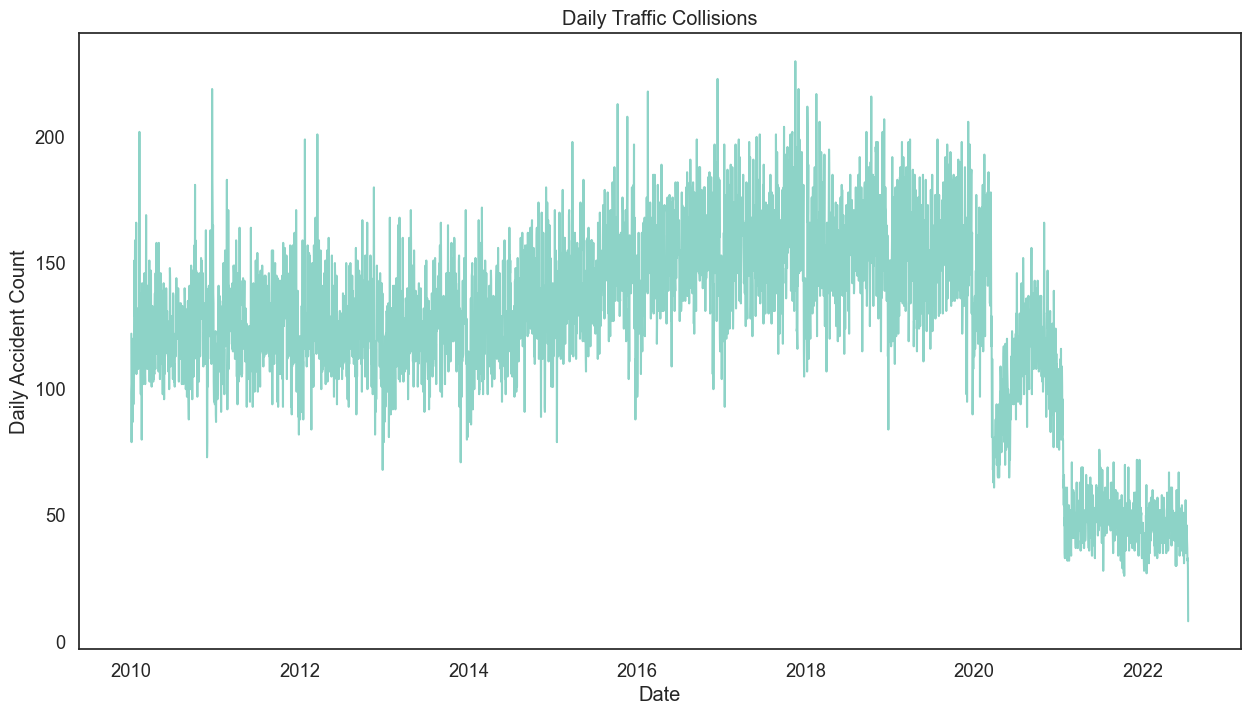

In [11]:
by_day = data.resample('D').sum()

fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=by_day, ax=ax, legend=False)

ax.set_title('Daily Traffic Collisions')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Accident Count')

#plt.savefig(fname='traffic-collisions_daily.png', dpi=150, bbox_inches='tight');

Here we can roughly see a range from, let's say, 100–150 accidents per day in 2011 increasing to something more like 125–200 per day by 2020, before dropping off starkly in tandem with the onset of the Covid-19 pandemic.

Let's try a monthly view to see if this clarifies the picture:

Text(0, 0.5, 'Monthly Accident Count')

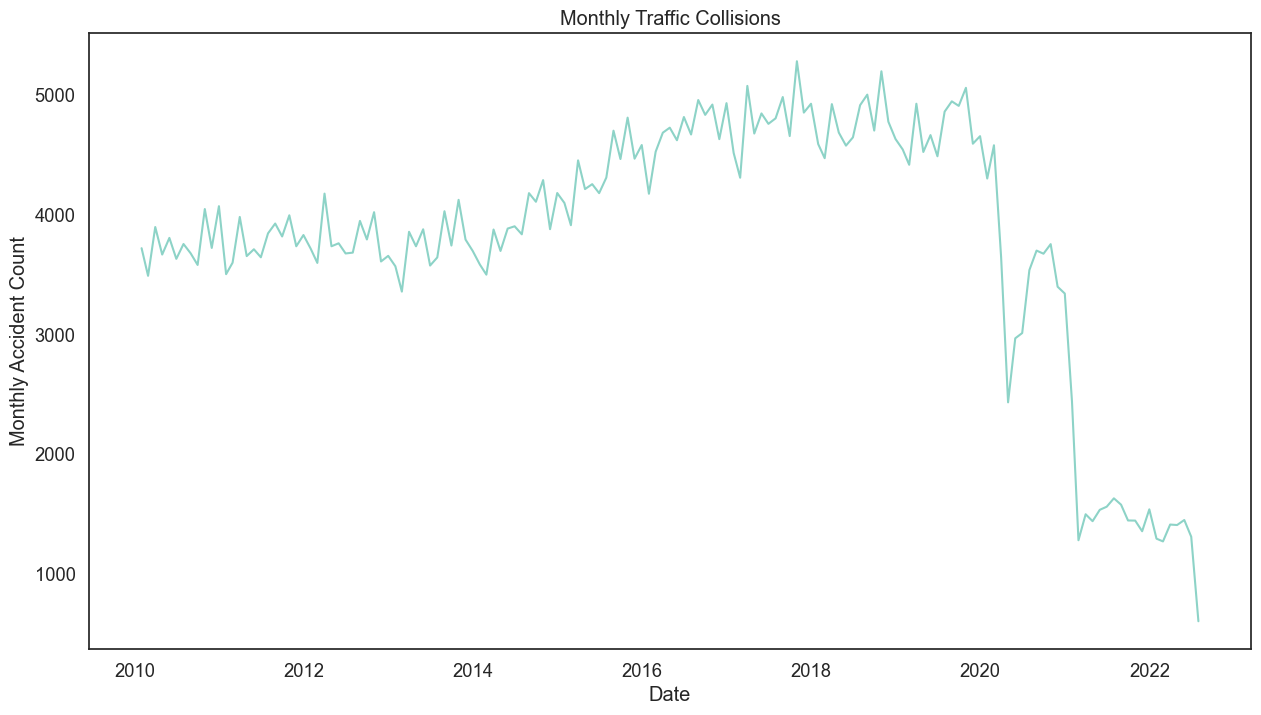

In [12]:
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(data=by_month, ax=ax, legend=False)

ax.set_title('Monthly Traffic Collisions')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Accident Count')

#plt.savefig(fname='traffic-collisions_monthly.png', dpi=150, bbox_inches='tight');

Besides the aforementioned increase in traffic accidents from 2010–2020 and the obvious Covid-related decline beginnin in early 2020, I'm not sure I see any patterns quite yet. Let's keep looking. Let's see how the number of accidents correlates with day of week.

Text(0.5, 0, 'Day of Week')

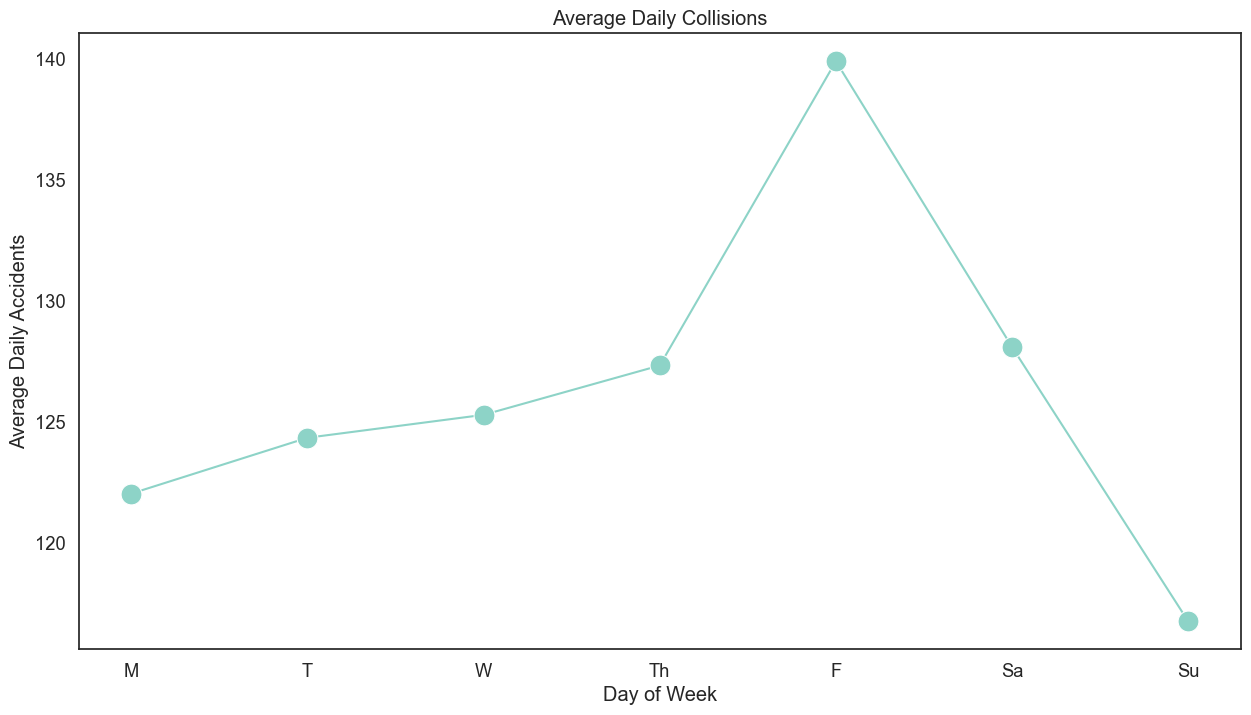

In [13]:
by_dayofweek = by_day.groupby(by_day.index.dayofweek).mean()
by_dayofweek.index = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']

fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=by_dayofweek, ax=ax, markers=True, markersize=15, legend=False)
ax.set_title('Average Daily Collisions')
ax.set_ylabel('Average Daily Accidents')
ax.set_xlabel('Day of Week')

#plt.savefig(fname='traffic-collisions_average-by-day.png', dpi=150, bbox_inches='tight');

Now we're starting to see some patterns. As any given week progresses, there are an increasing number of accidents per day, on average, with a dramatic spike on Fridays. Saturdays are significantly better, though still worse than Fridays, and Sundays see the lowest number of accidents.

I expect we'll also see some patterns if we chart accidents by time of day:

[Text(0, 0, '0:00'),
 Text(4, 0, '4:00'),
 Text(8, 0, '8:00'),
 Text(12, 0, '12:00'),
 Text(16, 0, '16:00'),
 Text(20, 0, '20:00')]

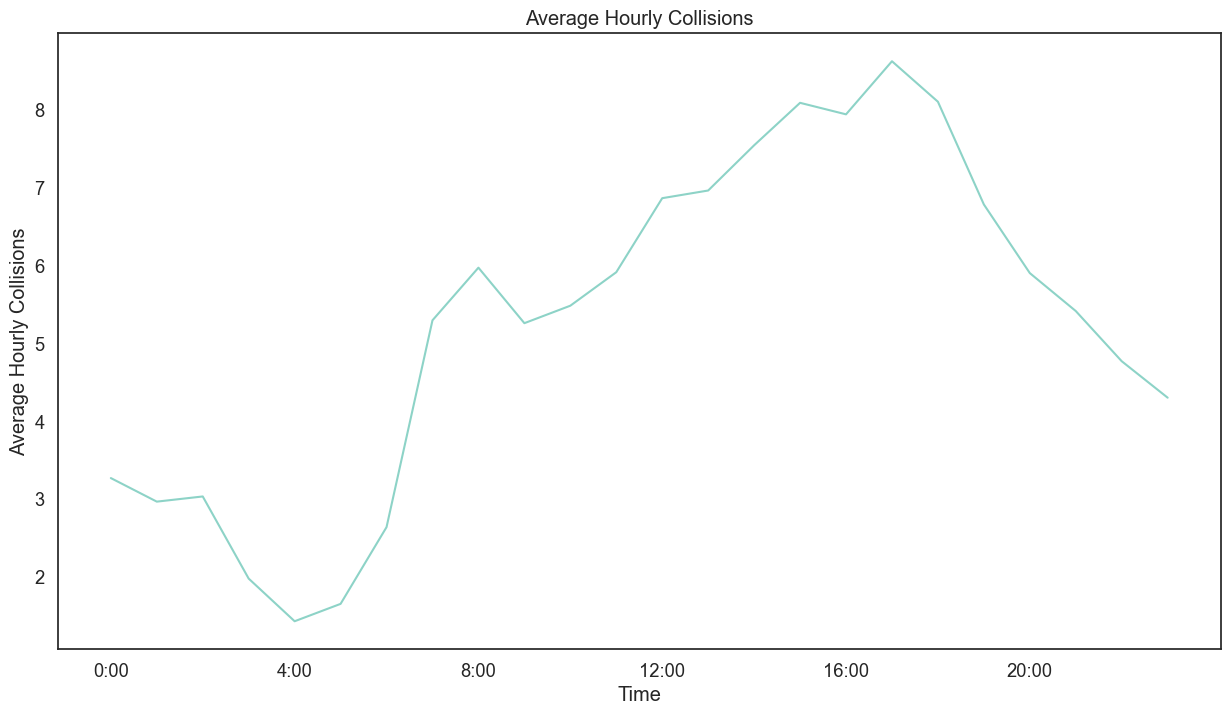

In [14]:
by_hour = data.resample('H').sum()

by_timeofday = by_hour.groupby(by_hour.index.time).mean()

ticks = 4 * np.arange(6)

fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x=np.arange(24), y=by_timeofday['accident_count'], ax=ax)

ax.set_title('Average Hourly Collisions')
ax.set_ylabel('Average Hourly Collisions')
ax.set_xlabel('Time')
ax.set_xticks(ticks)
ax.set_xticklabels(['{}:00'.format(x) for x in ax.get_xticks()])

#plt.savefig(fname='traffic-collisions_average-by-hour.png', dpi=150, bbox_inches='tight');

This isn't what I expected. I thought we'd see a higher incidence of accidents at night, but instead we see an early spike with morning rush hour at around 8:00 and then an evening rush hour spike at about 5:00pm. And actually this makes sense, since we're looking at total accidents (rather than accidents as a proportion of cars on the road, say), so in fact we would expect there to be more crashes when more people are driving. Duh.

Combined with the previous chart, we can imagine the TGIF situation as Angelenos rush home for the weekend after a long week at work. Let's check.

In [15]:
# Group by_hour by dayofweek and then by time
by_weekdaytime = (
    by_hour
    .groupby(by=[by_hour.index.dayofweek, by_hour.index.time])
    .mean()
    .reset_index()
)

by_weekdaytime.columns = ['day', 'time', 'accidents_per_hour']

# Remove colons from 'time' col and reformat as int
by_weekdaytime['time'] = by_weekdaytime['time'].astype('str').str[:2].astype('int')

by_weekdaytime

,day,time,accidents_per_hour
0,0,0,2.974006
1,0,1,2.463303
2,0,2,2.223242
3,0,3,1.492355
4,0,4,1.223242
...,...,...,...
163,6,19,6.133028
164,6,20,6.463303
165,6,21,5.925076
166,6,22,4.941896


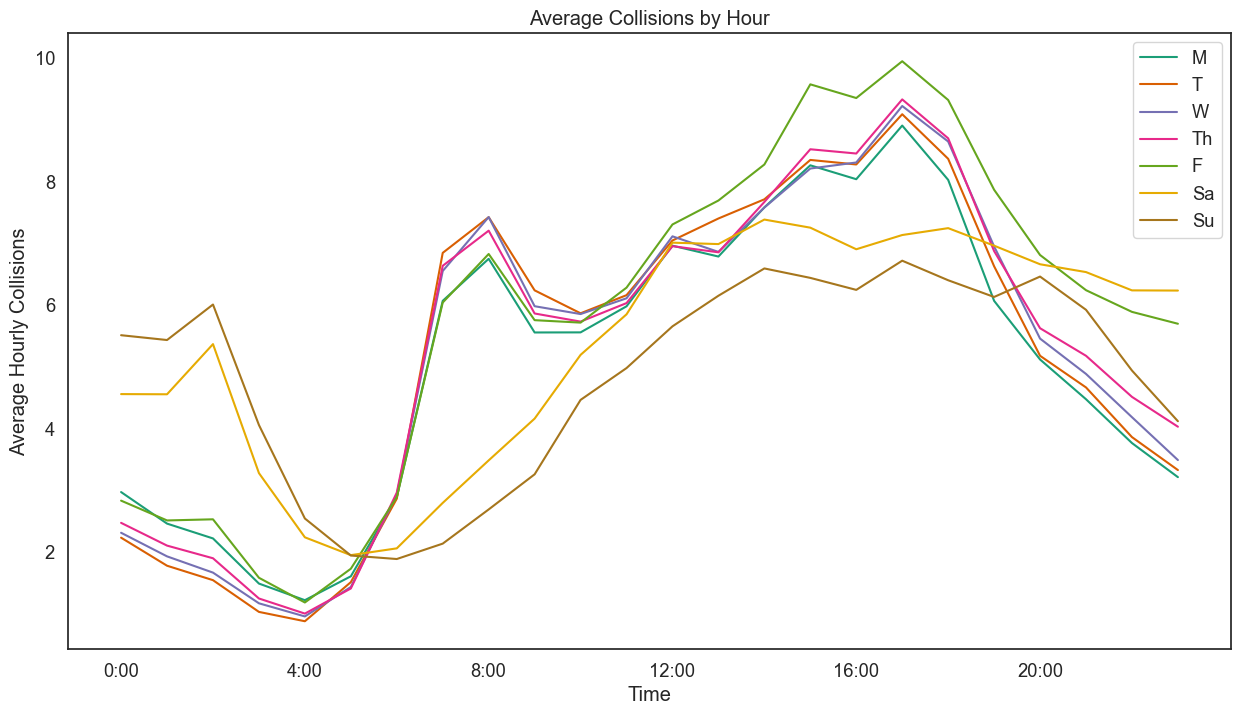

In [16]:
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(
    data=by_weekdaytime, 
    hue='day', 
    x='time', 
    y='accidents_per_hour', 
    ax=ax, 
    palette='Dark2'
)

# Set axis labels
ax.set_ylabel('Average Hourly Collisions')
ax.set_xlabel('Time')
ax.set_title('Average Collisions by Hour')

# Set x ticks
ax.set_xticks(ticks)
ax.set_xticklabels(['{}:00'.format(x) for x in ax.get_xticks()])

# Replace 0-6 with M-Su in legend
days = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']
h, l = ax.get_legend_handles_labels()
ax.legend(h, days)

#plt.savefig(fname='traffic-collisions_average-by-hour-by-day.png', dpi=150, bbox_inches='tight');

We can immediately sense a high level of correlation in average hourly accidents from Monday through Friday, with Friday's pattern being slightly anomalous. This weekday pattern confirms what we already discovered: a morning rush hour peak in accidents that gradually builds to a higher peak corresponding to the afternoon rush hour.

Meanwhile, the Saturday and Sunday patterns also seem to correlate closely and point to a different pattern: a spike in early morning accidents (presumably after bars let out), a morning lull when we would ordinarily see a weekday rush-hour spike, and a slow increase until the late afternoon.

For fun, let's see how correlated the days are:

Text(150.75, 0.5, 'Day of Week')

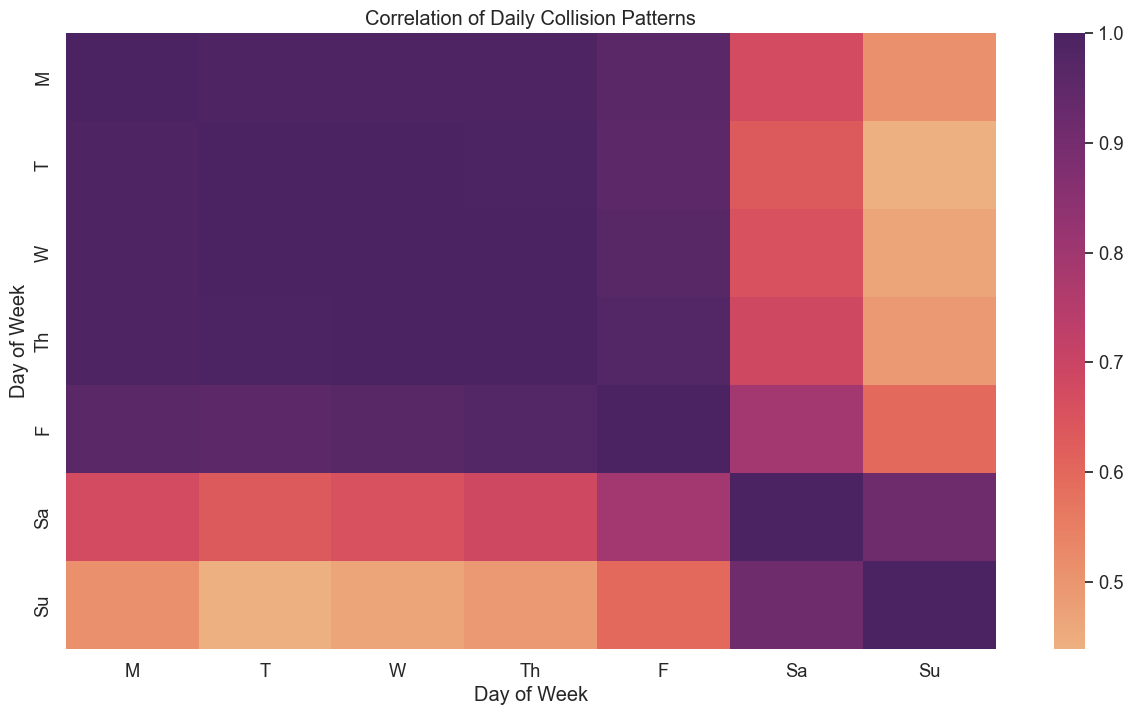

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))

by_weekdaytime_corr = (
    by_weekdaytime
    .set_index(['day', 'time'])['accidents_per_hour']
    .unstack(level=0)
    .corr()
)

sns.heatmap(by_weekdaytime_corr, ax=ax, xticklabels=days, yticklabels=days, cmap='flare')

ax.set_title('Correlation of Daily Collision Patterns')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Day of Week')

#plt.savefig(fname='traffic-collisions_daily-pattern-correlation.png', dpi=150, bbox_inches='tight');

This confirms what we saw above: A very high level of correlation between weekday days and a slightly lower but still high correlation between weekend days, plus some moderate correlation between Fridays and Saturdays.

In that case, perhaps we ough to clarify our chart above by looking just at weekdays and weekends.

[Text(0, 0, '0:00'),
 Text(4, 0, '4:00'),
 Text(8, 0, '8:00'),
 Text(12, 0, '12:00'),
 Text(16, 0, '16:00'),
 Text(20, 0, '20:00')]

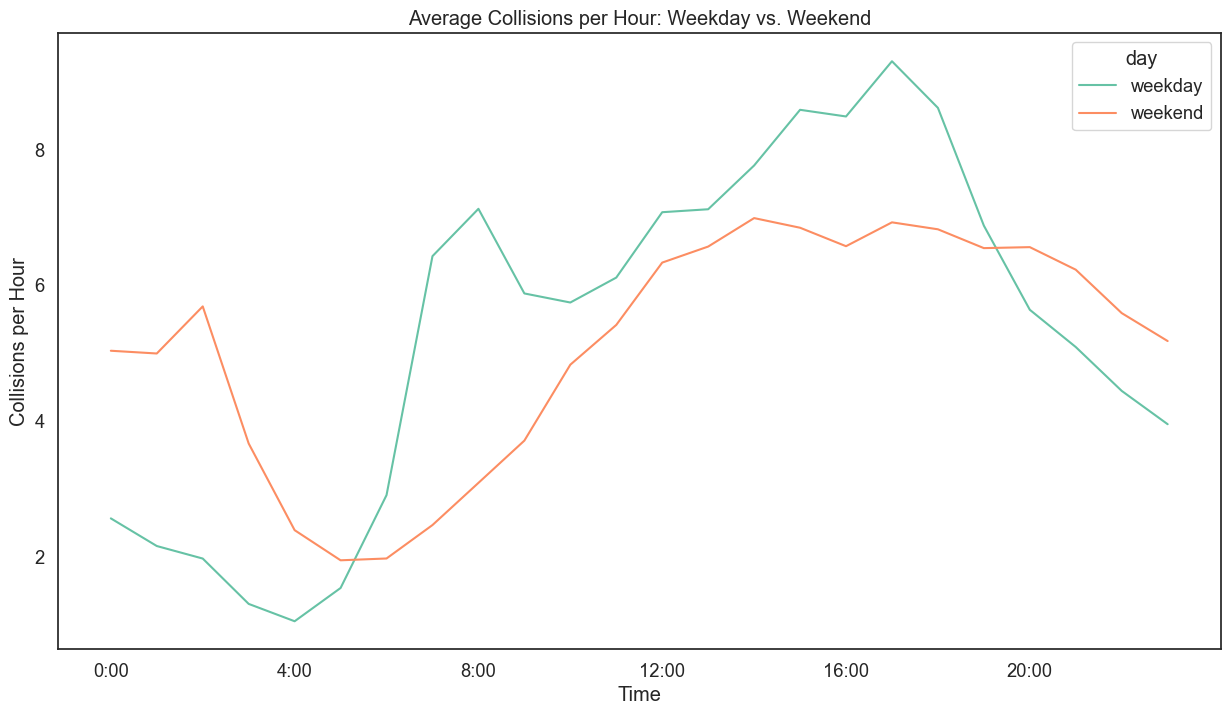

In [18]:
weekends = np.where(by_hour.index.dayofweek < 5, 'weekday', 'weekend')

by_weekends = (
    by_hour
    .groupby(by=[weekends, by_hour.index.time])
    .mean()
    .reset_index()
)

# Correct column names
by_weekends.columns = ['day', 'time', 'accidents_per_hour']

# Remove colons from 'time' col and retype as int
by_weekends['time'] = by_weekends['time'].astype('str').str[:2].astype('int')

fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(data=by_weekends, hue='day', x='time', y='accidents_per_hour', ax=ax, palette='Set2')

# Set axis labels
ax.set_title('Average Collisions per Hour: Weekday vs. Weekend')
ax.set_xlabel('Time')
ax.set_ylabel('Collisions per Hour')

# Set x-axis ticks
ax.set_xticks(ticks)
ax.set_xticklabels(['{}:00'.format(x) for x in ax.get_xticks()])

#plt.savefig(fname='traffic-collisions_average-by-hour_weekday-v-weekend.png', dpi=150, bbox_inches='tight');

There we have it.

Now I'm curious about particular dates that see abnormally high and low numbers of accidents.

In [19]:
by_monthandday = by_day.groupby(by=[by_day.index.month, by_day.index.day]).mean()
by_monthandday.index.names = ['month', 'day']
by_monthandday = by_monthandday.reset_index()

by_monthandday.sort_values(by='accident_count', ascending=False).head(10)

,month,day,accident_count
304,10,31,151.250000
305,11,1,148.583333
274,10,1,146.250000
325,11,21,145.333333
351,12,17,143.750000
347,12,13,143.583333
324,11,20,143.500000
277,10,4,143.250000
278,10,5,142.916667
290,10,17,142.666667


Okay, trick or treat! Halloween—both the day of and the day after—is the main culprit. I can't imagine what could be going on with some of these other dates like 10/1 and 11/21. My guess for the latter is that it falls somewhere in the leadup to Thanksgiving, perhaps the result of holiday travel. Similar situation for 11/20, and perhaps too for the late December dates. I'm not sure. Intersting nonetheless.

What about the days with the least number of accidents?

In [20]:
by_monthandday.sort_values(by='accident_count', ascending=False).tail(10)

,month,day,accident_count
364,12,30,108.583333
332,11,28,107.833333
6,1,7,107.384615
146,5,26,107.384615
2,1,3,107.000000
361,12,27,106.166667
362,12,28,104.333333
360,12,26,99.083333
1,1,2,96.846154
359,12,25,88.833333


No surprises here: Christmas day, the day after New Years Day, and other miscellaneous days right around the holidays when people are presumably home with family and not out and about.

Let's generate a chart to visualize the above accident trends for each calendar day:

Text(60, 105.38461538461539, "New Year's Day (115.38 collisions/day)")

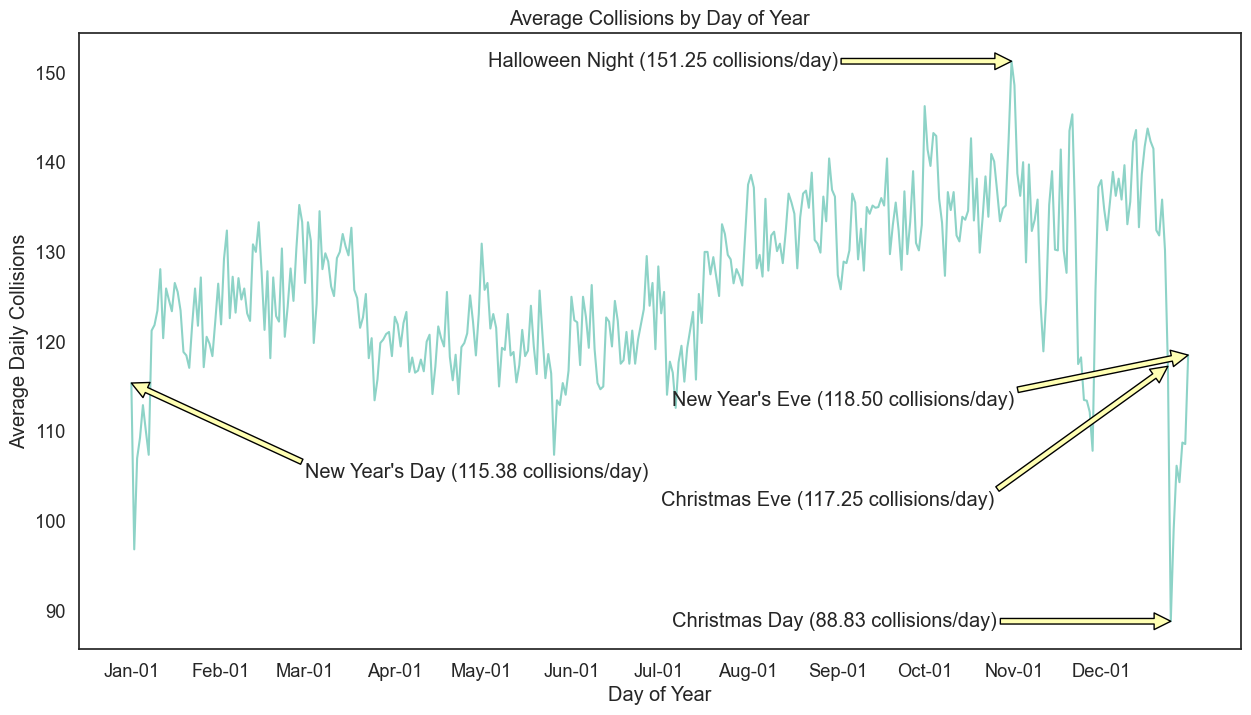

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(
    data=by_monthandday, 
    x=by_monthandday.index, 
    y='accident_count', 
    ax=ax
)

# Set xticks to align with the length of each month
# (Note that I am using 29 days for Feb to account for leap years)
days_per_month = np.array([0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30])
month_ticks = days_per_month.cumsum()
ax.set_xticks(month_ticks)

# Set xticklabels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels([m + '-01' for m in months]);

# Set labels
ax.set_title('Average Collisions by Day of Year')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Average Daily Collisions')

# Annotations
halloween = (by_monthandday['month'] == 10) & (by_monthandday['day'] == 31)
xmas_eve = (by_monthandday['month'] == 12) & (by_monthandday['day'] == 24)
xmas_day = (by_monthandday['month'] == 12) & (by_monthandday['day'] == 25)
ny_eve = (by_monthandday['month'] == 12) & (by_monthandday['day'] == 31)
ny_day = (by_monthandday['month'] == 1) & (by_monthandday['day'] == 1)

halloween_count = by_monthandday[halloween]['accident_count']
xmas_eve_count = by_monthandday[xmas_eve]['accident_count']
xmas_day_count = by_monthandday[xmas_day]['accident_count']
ny_eve_count = by_monthandday[ny_eve]['accident_count']
ny_day_count = by_monthandday[ny_day]['accident_count']

arrowprops = dict(edgecolor='black', facecolor=sns.color_palette('Set3').as_hex()[1], shrink=0)

ax.annotate(
    'Halloween Night ({:.2f} collisions/day)'.format(halloween_count.values[0]), 
    xycoords='data', xy=(halloween_count.index[0], halloween_count.values[0]),
    textcoords='data', xytext=(halloween_count.index[0]-60, halloween_count.values[0]), 
    arrowprops=arrowprops,
    horizontalalignment='right', 
    verticalalignment='center'
)
ax.annotate(
    'Christmas Eve ({:.2f} collisions/day)'.format(xmas_eve_count.values[0]), 
    xycoords='data', xy=(xmas_eve_count.index[0], xmas_eve_count.values[0]),
    textcoords='data', xytext=(xmas_eve_count.index[0]-60, xmas_eve_count.values[0]-15), 
    arrowprops=arrowprops,
    horizontalalignment='right', 
    verticalalignment='center'
)
ax.annotate(
    'Christmas Day ({:.2f} collisions/day)'.format(xmas_day_count.values[0]), 
    xycoords='data', xy=(xmas_day_count.index[0], xmas_day_count.values[0]),
    textcoords='data', xytext=(xmas_day_count.index[0]-60, xmas_day_count.values[0]), 
    arrowprops=arrowprops,
    horizontalalignment='right', 
    verticalalignment='center'
)
ax.annotate(
    'New Year\'s Eve ({:.2f} collisions/day)'.format(ny_eve_count.values[0]), 
    xycoords='data', xy=(ny_eve_count.index[0], ny_eve_count.values[0]),
    textcoords='data', xytext=(ny_eve_count.index[0]-60, ny_eve_count.values[0]-5), 
    arrowprops=arrowprops,
    horizontalalignment='right', 
    verticalalignment='center'
)
ax.annotate(
    'New Year\'s Day ({:.2f} collisions/day)'.format(ny_day_count.values[0]), 
    xycoords='data', xy=(ny_day_count.index[0], ny_day_count.values[0]),
    textcoords='data', xytext=(ny_day_count.index[0]+60, ny_day_count.values[0]-10), 
    arrowprops=arrowprops,
    horizontalalignment='left', 
    verticalalignment='center'
)

#plt.savefig(fname='traffic-collisions_average-by-day-of-year.png', dpi=150, bbox_inches='tight');

This just helps us see what we already know, plus a little more. We can quickly see the Halloween and other holiday spikes as well as the holiday lows around Thanksgiving time and Christmas time. We also see something that we didn't observe before, namely a summertime lull, which makes sense since school is out (again, less cars on the road, thus less accidents).